In [1]:
# import libs
import polars as pl
import pandas as pd
import numpy as np

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

# yellow brick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

# models
import umap
import umap.plot

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/thomson/DS3000Project/venv/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/thomson/DS3000Project/venv/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/thomson/DS3000Project/venv/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  wa

In [2]:
#testing code with separate csv file
df = pl.read_csv("clustering.csv")
length = len(df)
ten_per = length*0.1

df_10 = df.sample(n=ten_per, seed = 2025)

df_pd = df_10.to_pandas() # convert to pandas 

# variance thresholding: remove constant variance variables
selector = VarianceThreshold(threshold=0.01)  
df_reduced = selector.fit_transform(df_pd)

# get the final df to cluster 
selected_columns = df_pd.columns[selector.get_support()]
df_reduced = pd.DataFrame(df_reduced, columns=selected_columns)
print(f"{len(df_reduced.columns)} columns left after variance thresholding")
dropped_columns = df_pd.columns[~selector.get_support()] # check number of columns dropped 
print(f"Dropped {len(dropped_columns)} columns due to low variance: + {dropped_columns}")

# correlation filtering: remove colinearity for clustering 
threshold = 0.9 
corr_matrix = df_reduced.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)] # Identify columns to drop

df_final = df_reduced.drop(columns=to_drop)
dropped_cols = to_drop

print(f"{len(df_final.columns)} columns left after correlation filtering")
print(f"{len(dropped_cols)} columns dropped from correlation filtering, {dropped_cols}")

# scale the features after correlation filtering 
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_final)

647 columns left after variance thresholding
Dropped 84 columns due to low variance: + Index(['ECYMOTCREO', 'ECYMOTCZEC', 'ECYHOMCHIN', 'ECYHOMDUTC', 'ECYHOMHUNG',
       'ECYHOMCROA', 'ECYHOMCREO', 'ECYHOMJAPA', 'ECYHOMTURK', 'ECYHOMCZEC',
       'ECYHOMMNON', 'ECYTIMONAM', 'ECYTIMCUBA', 'ECYTIMCHIL', 'ECYTIMPERU',
       'ECYTIMCZEC', 'ECYTIMHUNG', 'ECYTIMIREL', 'ECYTIMCAFO', 'ECYTIMOSAF',
       'ECYTIMOEA', 'ECYTIMCAMB', 'ECYTIMMALA', 'ECYTIMOSA', 'ECYTIMFIJI',
       'ECYTIMOOCE', 'ECYRIMCAM', 'ECYRIMMEXI', 'ECYRIMCAO', 'ECYRIMCUBA',
       'ECYRIMHAIT', 'ECYRIMJAMA', 'ECYRIMCBO', 'ECYRIMBRAZ', 'ECYRIMCOLO',
       'ECYRIMVENE', 'ECYRIMSAO', 'ECYRIMGERM', 'ECYRIMWEO', 'ECYRIMEEU',
       'ECYRIMMOLD', 'ECYRIMPOLA', 'ECYRIMROMA', 'ECYRIMRUSS', 'ECYRIMUKRA',
       'ECYRIMEEO', 'ECYRIMNEU', 'ECYRIMUK', 'ECYRIMNEO', 'ECYRIMSEU',
       'ECYRIMCOTE', 'ECYRIMWAFO', 'ECYRIMERIT', 'ECYRIMETHI', 'ECYRIMKENY',
       'ECYRIMSOMA', 'ECYRIMEAFO', 'ECYRIMALGE', 'ECYRIMEGYP', 'ECYRIMMORO',
   

## Clustering and Dimensionality Reduction

### b. KMeans clustering

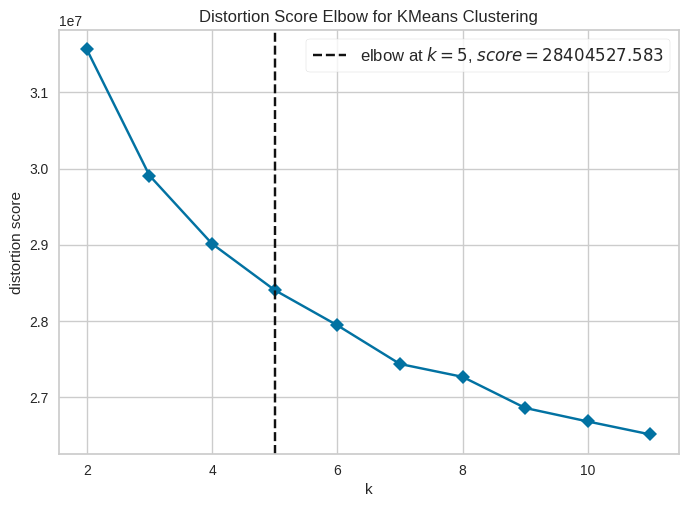

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [4]:
## Finding ideal number of clusters using Elbow Method

#initializing KClusterer
KClusterer = KMeans(random_state=42)
1
# KElbow visualizer
visualizer = KElbowVisualizer(KClusterer,
                              k=(2,12),
                              locate_elbow=True,
                              timings=False
                             )

# fitting the visualizer and displaying
visualizer.fit(df_scaled)
visualizer.show()

The silhouette score for K-means with 2 clusters is 0.483


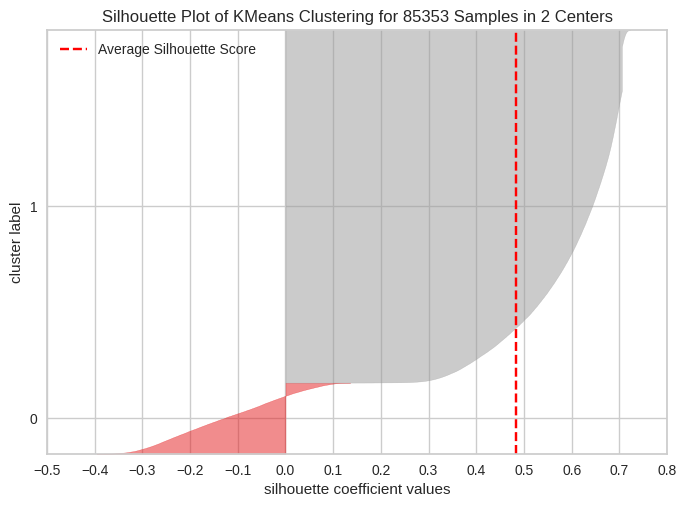

The silhouette score for K-means with 3 clusters is 0.311


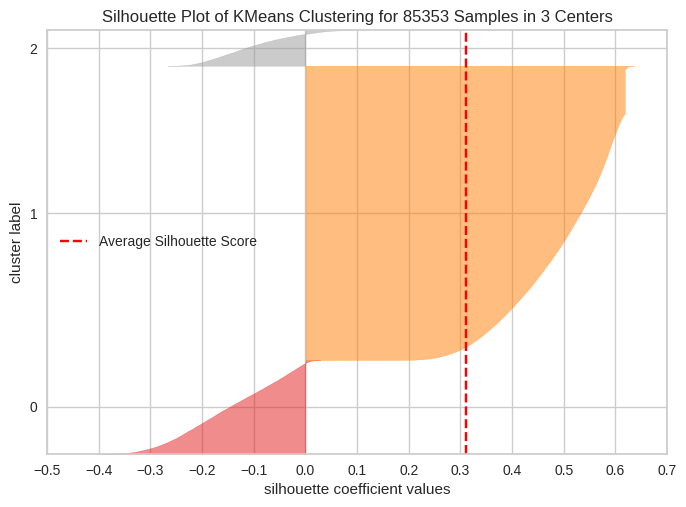

The silhouette score for K-means with 4 clusters is 0.279


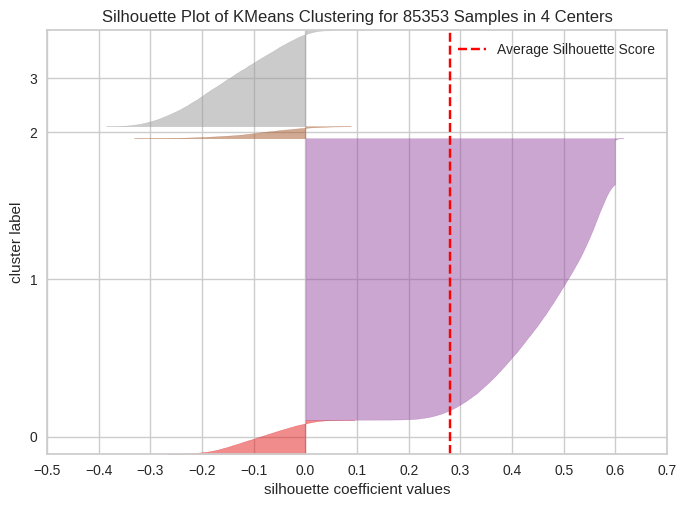

The silhouette score for K-means with 5 clusters is 0.184


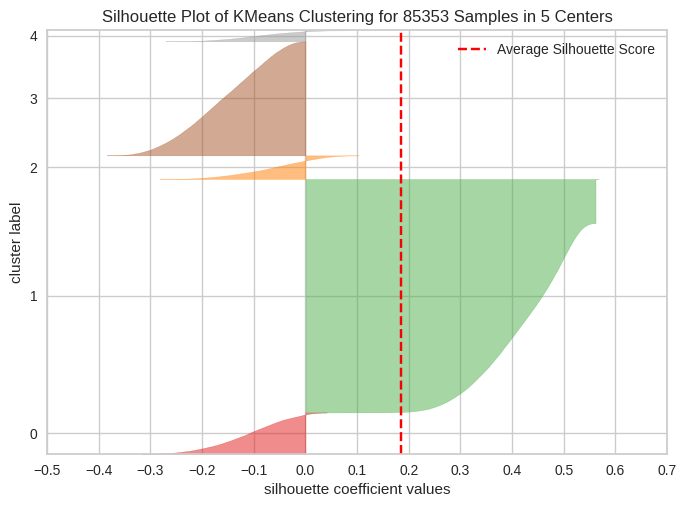

The silhouette score for K-means with 6 clusters is 0.011


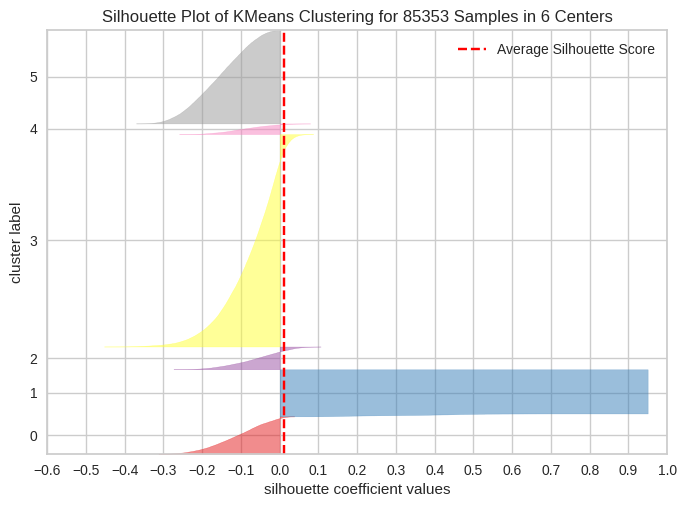

The silhouette score for K-means with 7 clusters is 0.014


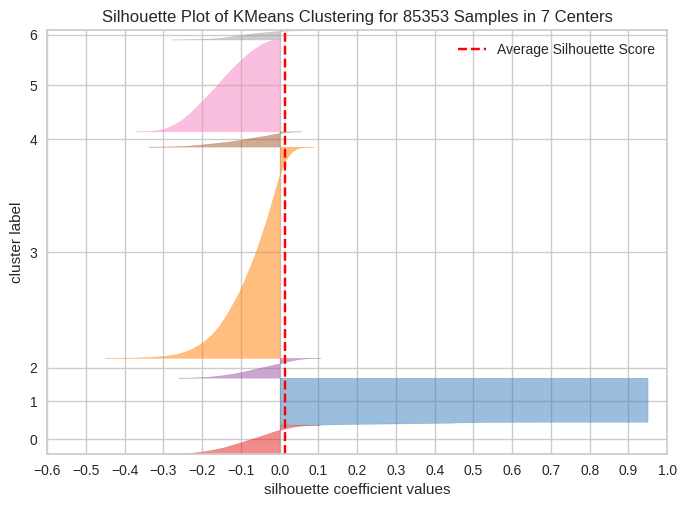

The silhouette score for K-means with 8 clusters is 0.102


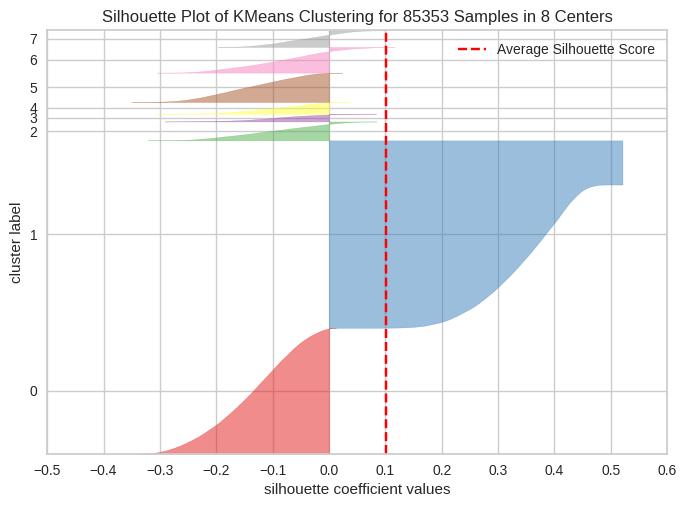

The silhouette score for K-means with 9 clusters is 0.023


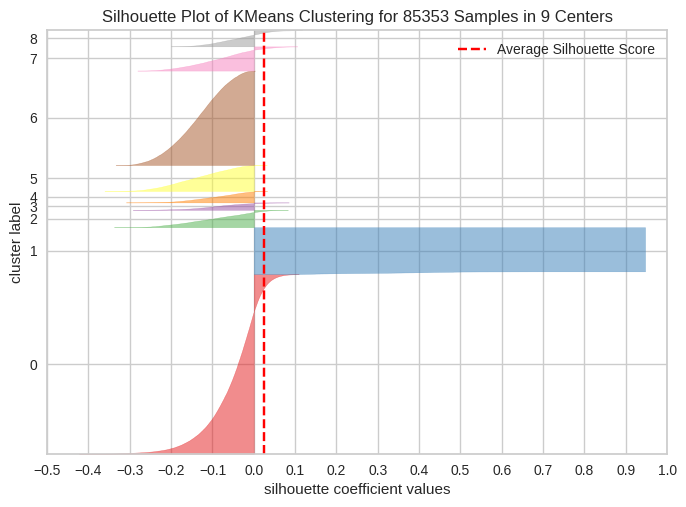

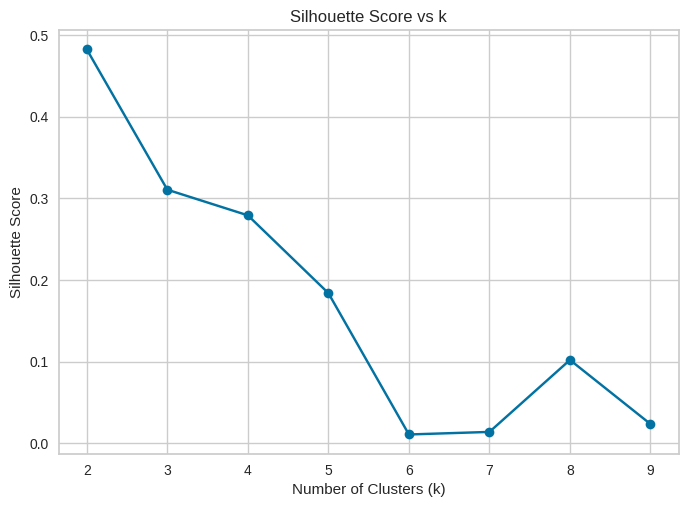

In [14]:
## Finding ideal number of clusters using Silhouette Method

scores = []
# for loop to get silhouette score of 3-8 clusters
for i in range(2, 10):
  kmeans_pipe = Pipeline([ 
    ('aggcl', KMeans(n_clusters=i, random_state=42))
  ])

  # fitting pipe to the scaled df 
  kmeans_pipe.fit(df_scaled)
  cluster_labels = kmeans_pipe.predict(df_scaled)

  # getting silhouette score
  score = silhouette_score(df_scaled, cluster_labels)
  scores.append((i, score))
  print(f'The silhouette score for K-means with {i} clusters is {round(score, 3)}')

  # plotting a silhouette plot for k-means using yellowbricks
  visualizer = SilhouetteVisualizer(kmeans_pipe.named_steps['aggcl'])
  visualizer.fit(df_scaled)
  visualizer.show()

# plot the silhouette scores 
x, y = zip(*scores)
plt.plot(x,y, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs k")
plt.grid(True)
plt.show()

The ideal number of clusters according to the Elbow is 5, and the ideal number of clusters according to Silhouette is 2. The results do not agree with one another, likely because the Elbow method tends to detect more compact and local patterns, while Silhouette gives a higher score to clusters with more distinct global structures. The Elbow method tends to find more compact regions and rewards more fine-grained substructures within a group and split it further into another cluster, likely due to how the Elbow method measures how close data points are to their assigned cluster center, and aims to minimize the variance within each cluster. 

In [3]:
## KMeans cluster graph with ideal cluster

# creating KClusterer with ideal number of clusters
KClusterer = KMeans(n_clusters=2,
                    verbose=0,
                    random_state=42)


#fitting the data
cluster_labels = KClusterer.fit_predict(df_scaled) # cluster using scaled vals 
df_scaled_df = pd.DataFrame(df_scaled, columns=df_final.columns)  

# Add cluster labels
df_scaled_df["cluster_label"] = cluster_labels

### c. PCA 

#### i. Applying PCA 

In [4]:
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD

# initialize and fit the PCA 
pca = PCA(n_components=len(df_final.columns), random_state=42)  
X_pca = pca.fit_transform(df_scaled)

# Generate dynamic PC names
pc_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]

# initialize df of the 3 principal components and cluster labels 
pca_df = pd.DataFrame(X_pca, columns=pc_names)
pca_df["cluster"] = cluster_labels
print(len(pca_df.columns))

462


#### ii. Plotting PCA

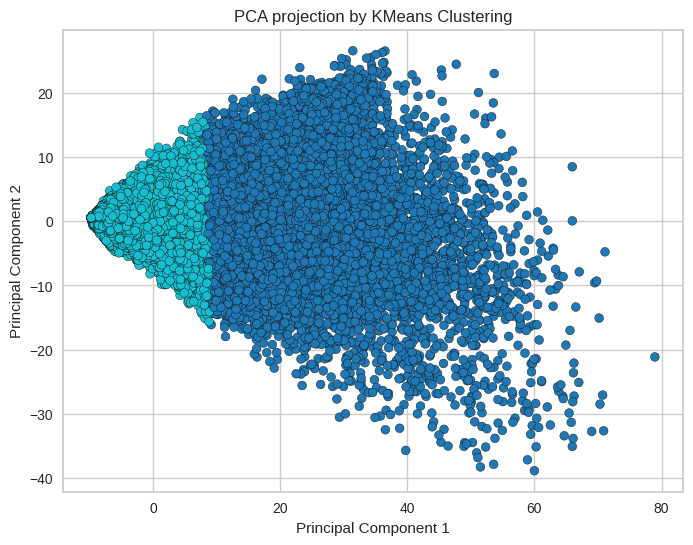

In [5]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_df["PC1"], pca_df["PC2"], c=pca_df["cluster"], cmap="tab10", s=40, edgecolor="k")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA projection by KMeans Clustering")
plt.grid(True)
plt.show()

### What can we say about the data? Are the clusters clearly defined?


In [11]:
# check the top 10 variables for each pc 
loading_df = pd.DataFrame(pca.components_.T,
                          index=df_final.columns,
                          columns=pc_names)

for i in range(0, 3):
    print(f"Variance of Principal Component {i + 1}: {pca.explained_variance_ratio_[i]*100:.2f}%")


# load top contributors to the 3 PCs 
top10_pc1 = loading_df["PC1"].abs().sort_values(ascending=False).head(10)
top10_pc2 = loading_df["PC2"].abs().sort_values(ascending=False).head(10)
top10_pc3 = loading_df["PC3"].abs().sort_values(ascending=False).head(10)

print(top10_pc1, "\n")
print(top10_pc2, "\n")
print(top10_pc3, "\n")
print(len(loading_df.columns))
print(loading_df.shape)

Variance of Principal Component 1: 27.92%
Variance of Principal Component 2: 4.26%
Variance of Principal Component 3: 3.20%
ECYBAS12P     0.080193
ECYPTA5054    0.078345
ECYPTA4549    0.078249
ECYHNI100P    0.077932
ECYMOBNMOV    0.077260
HSFD995       0.077114
ECYPTA5559    0.076749
ECYHSZ3PER    0.076644
HSHF001S      0.076105
ECYOCCBFAD    0.075688
Name: PC1, dtype: float64 

ECYTIMA       0.118319
ECYHOMENON    0.112980
ECYMOTNOFF    0.106278
ECYMOTENON    0.105288
ECYVISNVM     0.101052
ECYAIM2544    0.100546
ECYKNONEF     0.098559
ECYPIM0110    0.096083
ECYTIMSA      0.096047
ECYGEN1GEN    0.095479
Name: PC2, dtype: float64 

ECYSTYAPT     0.143304
ECYTENRENT    0.140720
ECYCDORENC    0.133972
HSSH006       0.126757
ECYHNI2040    0.123684
HSRM005       0.123290
HSRM002A      0.122932
HSRM013       0.121464
ECYHNIAVG     0.121022
ECYSTYAPU5    0.120685
Name: PC3, dtype: float64 

461
(461, 461)


### Interpretation of the top 3 components and what they represent

#### Variables of PC 1:
- `ECYBAS12P`: Total population 12 years old or over
- `ECYPTA5054`: Total population aged 50-54 years old
- `ECYPTA4549`: Total population aged 45-49 years old
- `ECYHNI100P`: Total households with current year income of $100,000 or over 
- `ECYMOBNMOV`: Total household population that are non movers 
- `HSFD995`: Spendings on restaurant snacks and beverages 
- `ECYPTA5559`: Total population aged 55-59 years old 
- `ECYHSZ3PER` Total households with 3 people
- `HSHF001S`: Spendings on household furnishings and equipment 
- `ECYOCCBFAD`: Total household population 15 years or over in business finance administration 

#### Variables of PC 2:
- `ECYTIMA`: Total household population that are American immigrants 
- `ECYHOMENON`: Total household population speaking English and non-official languages at home
- `ECYMOTNOFF`: Total household population with non-official languages as the mother tongue 
- `ECYMOTENON`: Total household population with English and non-official languages as the mother tongue 
- `ECYVISNVM`: Total household population that are not visible minorities 
- `ECYAIM2544`: Total household population of immigrants aged 25-44 years 
- `ECYKNONEF`: Total household population that know neither English nor French
- `ECYPIM0110`: Total household population that migrated from 2001-2010
- `ECYTIMSA`: Total household population that are immigrants and are born in South America 
- `ECYGEN1GEN`: Total household population that are first generation


#### Variables of PC 3:
- `ECYSTYAPT`: Total occupied dwellings that are apartments with both low and high rise     
- `ECYTENRENT`: Total occupied dwellings that are rented
- `ECYCDORENC`: Total occupied private dwellings that are rented and not in condo
- `HSSH006`: Total spendings on tenants' insurance premiums 
- `ECYHNI2040`: Total households with income from $20,000 to $39,999
- `HSRM005`: Total spendings on fences, driveways, patios, swimming pools, hot tubs and ponds
- `HSRM002A`: Total spendings on exterior painting or staining 
- `HSRM013`: Total spendings on heating and/or air conditioning equipment        
- `ECYHNIAVG`: Average household income for the current year
- `ECYSTYAPU5`: Number of occupied buildings that are apartments with fewer than 5 stories

To briefly summarize the variables of the Principal Components such that each PC can be categorized to a certain demographic:
- PC1 represents smaller sized households with high income and spending.  
- PC2 represents middle-aged immigrants and first generation residents that migrated from 2001-2010 and speak English or non-official languages.   
- PC3 represents the middle class with incomes of $20,000 to $39,999. 

#### iii. Calculating average of first 3 components for both clusters

In [25]:
cluster_means = pca_df.groupby("cluster")[["PC1", "PC2", "PC3"]].mean().round(2)
print(cluster_means) 

           PC1   PC2   PC3
cluster                   
0        21.25  0.72  0.16
1        -4.28 -0.15 -0.03


##### Table interpretation

The table shows the mean values of each principal component for the 2 clusters. It shows how much each cluster's center is aligned with the principal components' axes, and how strongly the structure captured by the principal component is present in said cluster.

Cluster 1 (indexxed as cluster 0) has the highest average on PC1, while cluster 2 has the highest average on PC3. 

This shows that cluster 1 aligns most with PC1, where cluster 1 can be said to represent a demographic with high spending, small family size and high annual income of $100,000+ that have stable livings in the business finance administration industry. Cluster 2 (indexxed as cluster 1) has the highest average of -0.03 on PC3, where PC3 represents cluster 3 better than the other principal components. Given that a k of 2 was chosen over a k of 5 from the elbow method which favors more compact structures due to the way inertia is calculated. We infer that PC3 likely contains mixed noises about several demographics that could be divided into individual clusters as suggested by the k value from the elbow method, but we can conclude from PC3 that cluster 2 likely contains middle class citzens with incomes of $20,000-$39,999. 

### d. UMAP

/home/thomson/DS3000Project/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(angular_rp_forest=True, low_memory=False, metric='cosine', min_dist=0.3, n_epochs=1000, n_neighbors=30, verbose=True)
Sat Apr 19 21:55:37 2025 Construct fuzzy simplicial set
Sat Apr 19 21:55:37 2025 Finding Nearest Neighbors
Sat Apr 19 21:55:37 2025 Building RP forest with 20 trees
Sat Apr 19 21:55:42 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	Stopping threshold met -- exiting after 6 iterations
Sat Apr 19 21:55:58 2025 Finished Nearest Neighbor Search
Sat Apr 19 21:56:00 2025 Construct embedding


Epochs completed:   0%|            0/1000 [00:00]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Sat Apr 19 21:56:30 2025 Finished embedding


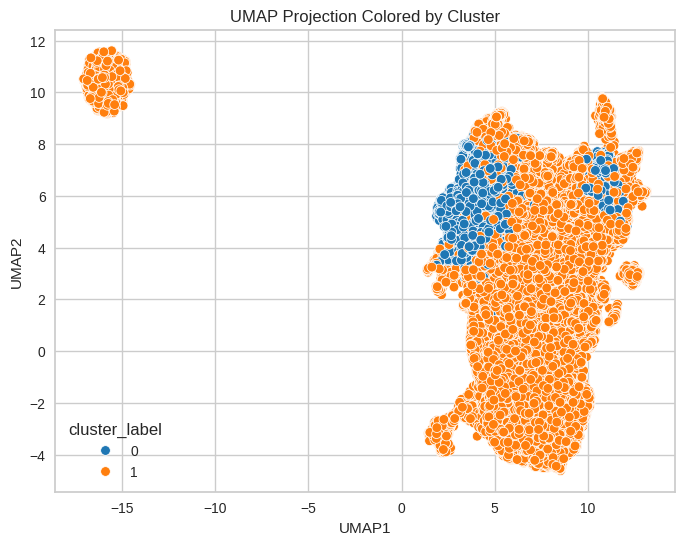

In [12]:
reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric='cosine',
                    n_epochs=1000,
                    min_dist=0.3,
                    spread=1.0,
                    low_memory=False,
                    n_jobs=-1,
                    verbose=True)

UMAP_embedding = reducer.fit_transform(df_scaled)
df_umap = pd.DataFrame(UMAP_embedding, columns=["UMAP1", "UMAP2"])

df_umap["cluster_label"] = cluster_labels

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="UMAP1", y="UMAP2", hue="cluster_label", data=df_umap, palette="tab10")
plt.title("UMAP Projection Colored by Cluster")
plt.grid(True)
plt.show()

# UMAP interpretation

THe UMAP mostly aligns with the clusters visualized by PCA. Since the local structure is preserved at the cost of distorting global data structure, we can clearly see that the clusters are somewhat closely aligned and overlap with each other compared to PCA. Although the PCA plot shows a more clear divide between clusters, there is a lot more overlap in the UMAP since UMAP prioritizes local neighboring relationships, which can pull points from separate clusters together in the low-dimensional embedding, compared to PCA, which projects data to capture the directions of maximum global variance. UMAP may compress or distort distances between clusters to improve the representation of local structures. Thus, UMAP may display well-separated clusters in higher dimensions as slightly overlapping, if samples are considered close neighbors like at cluster boundaries. On the other hand, PCA treats the dataset as a whole globally and may exaggerate global separation for clarity, so clusters may appear more distinct than they actually are in the PCA visualization.

To summarize, although UMAP blurs the cluster boundary and causes overlap, it is a better representation of the data because there is more information about local structure that is preserved in this low dimensional embedding than that of PCA's, although PCA's exaggerated separation makes it easy to visualize distinct clusters as a result of the uncorrelated principal components. UMAP can display more detailed relationships between data points that may not be projected in PCA, which we consider more vital to our analysis of the data.
